In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import pandas as pd
import numpy as np

In [89]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")
# model.to(device)

The model will be running on cpu device


# Clean Excel

In [2]:
excel_data = pd.read_csv("sentiment.csv")
del excel_data['Unnamed: 0']
excel_data.drop(excel_data[excel_data.filename == 'COCO_val2014_000000130712.jpg'].index , inplace=True)
excel_data.drop(excel_data[excel_data.filename == 'COCO_val2014_000000310622.jpg'].index , inplace=True)
excel_data.drop(excel_data[excel_data.filename == 'COCO_val2014_000000421673.jpg'].index , inplace=True)
excel_data.drop(excel_data[excel_data.filename == 'COCO_val2014_000000359276.jpg'].index , inplace=True)
excel_data.sentiment.value_counts()

1    21229
0    17880
Name: sentiment, dtype: int64

# Define Model

In [7]:
class MyModel_Multi(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=4096, out_features=2500)
        self.fc2 = nn.Linear(in_features=2500, out_features=2000)
        self.fc3 = nn.Linear(in_features=2000, out_features=1000)
        
        
        self.fj1 = nn.Linear(in_features=2000, out_features=1000)
        self.fj2 = nn.Linear(in_features=1000, out_features=500)
        self.fj3 = nn.Linear(in_features=500, out_features=50)
        self.fj4 = nn.Linear(in_features=50, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x1, x2):
        """for images alone"""
        print("\n...x1...")
        x1 = self.fc1(x1)
        x1 = self.sigmoid(x1)
        x1 = self.fc2(x1)
        x1 = self.sigmoid(x1)
        x1 = self.fc3(x1)
        x1 = self.sigmoid(x1)
        
        
        """for text  only"""
        print("\n...x2...")
        x2 = self.fc1(x2)
        x2 = self.sigmoid(x2)
        x2 = self.fc2(x2)
        x2 = self.sigmoid(x2)
        x2 = self.fc3(x2)
        x2 = self.sigmoid(x2)
        
        """combining image and text neurons"""
        print("\n...x3...")
        x3 = torch.cat((x1, x2), dim=1)
        print("after concat: ",len(x3[0]))
        
        x3 = self.fj1(x3)
        x3 = self.sigmoid(x3)
        
        x3 = self.fj2(x3)
        x3 = self.sigmoid(x3)
        
        x3 = self.fj3(x3)
        x3 = self.sigmoid(x3)
        
        x3 = self.fj4(x3)
        x3 = self.sigmoid(x3)
        
        print("return: ",len(x3[0]))
        return x3

# Load data

In [3]:
with open('text_tensors.pkl', 'rb') as f:
    text_tensors = pickle.load(f)

In [4]:
with open('image_tensors.pkl', 'rb') as f:
    image_tensors = pickle.load(f)

In [5]:
print(text_tensors.shape, text_tensors.dtype)
print(image_tensors.shape, image_tensors.dtype)

torch.Size([39109, 4096]) torch.float32
torch.Size([39109, 4096]) torch.float32


# labels from dataframe to tensor

In [6]:
sentiment = excel_data['sentiment'] # assuming 'sentiment' is a pandas series object
sentiment_array = np.array([sentiment.to_numpy()]).T
image_labels = torch.tensor(sentiment_array, dtype=torch.float32)

In [11]:
text_tensors

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

# split dataset to train and test

In [12]:
def split(train_size = 0.8):
    if train_size > 1:
        print("sending default 0.8 train size")
        ret = split(0.8)
        return ret
    else:
        rows = int(len(image_tensors)*train_size)
        data = [image_tensors[:rows, :], text_tensors[:rows, :], image_labels[:rows, :], image_tensors[rows:, :], text_tensors[rows:, :], image_labels[rows:, :] ]
        return data

In [13]:
# train = [image_tensors[:rows, :], text_tensors[:rows, :], image_labels[:rows, :]]
train_image, train_text, train_label, test_image, test_text, test_label = split(0.8)


In [14]:
print(len(train_image), len( image_tensors))
print(len(train_text), len( text_tensors))
print(len(train_label), len(image_labels))

print('test')
print(len(test_image), len( image_tensors))
print(len(test_text), len( text_tensors))
print(len(test_label), len(image_labels))

31287 39109
31287 39109
31287 39109
test
7822 39109
7822 39109
7822 39109


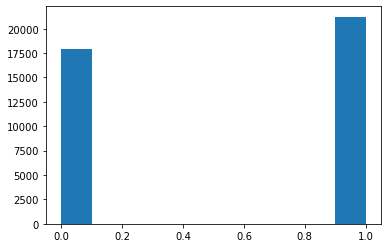

In [15]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.hist(np.array(excel_data['sentiment']));

# Train

In [13]:
# Instantiate the model and define the loss function and optimizer # model = MyModel()
model = MyModel_Multi()
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [46]:
# Train the model
for epoch in range(100):
    
    # Forward pass
    outputs = model(train_image, train_text)
    loss = criterion(outputs, train_label)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print progress
    if (epoch+1) % 1 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
        


...x1...

...x2...

...x3...
after concat:  2000
return:  1
Epoch [1/100], Loss: 0.2486

...x1...

...x2...

...x3...
after concat:  2000
return:  1
Epoch [2/100], Loss: 0.2486

...x1...

...x2...

...x3...
after concat:  2000
return:  1
Epoch [3/100], Loss: 0.2486

...x1...

...x2...

...x3...
after concat:  2000
return:  1
Epoch [4/100], Loss: 0.2486

...x1...

...x2...

...x3...
after concat:  2000
return:  1
Epoch [5/100], Loss: 0.2486

...x1...

...x2...

...x3...
after concat:  2000
return:  1
Epoch [6/100], Loss: 0.2486

...x1...

...x2...

...x3...
after concat:  2000
return:  1
Epoch [7/100], Loss: 0.2486

...x1...

...x2...

...x3...
after concat:  2000
return:  1
Epoch [8/100], Loss: 0.2486

...x1...

...x2...

...x3...
after concat:  2000
return:  1
Epoch [9/100], Loss: 0.2486

...x1...

...x2...

...x3...
after concat:  2000
return:  1
Epoch [10/100], Loss: 0.2486

...x1...

...x2...

...x3...
after concat:  2000
return:  1
Epoch [11/100], Loss: 0.2486

...x1...

...x2...


...x3...
after concat:  2000
return:  1
Epoch [92/100], Loss: 0.2485

...x1...

...x2...

...x3...
after concat:  2000
return:  1
Epoch [93/100], Loss: 0.2485

...x1...

...x2...

...x3...
after concat:  2000
return:  1
Epoch [94/100], Loss: 0.2485

...x1...

...x2...

...x3...
after concat:  2000
return:  1
Epoch [95/100], Loss: 0.2485

...x1...

...x2...

...x3...
after concat:  2000
return:  1
Epoch [96/100], Loss: 0.2485

...x1...

...x2...

...x3...
after concat:  2000
return:  1
Epoch [97/100], Loss: 0.2485

...x1...

...x2...

...x3...
after concat:  2000
return:  1
Epoch [98/100], Loss: 0.2485

...x1...

...x2...

...x3...
after concat:  2000
return:  1
Epoch [99/100], Loss: 0.2485

...x1...

...x2...

...x3...
after concat:  2000
return:  1
Epoch [100/100], Loss: 0.2485


In [51]:
model.eval()

MyModel_Multi(
  (fc1): Linear(in_features=4096, out_features=2500, bias=True)
  (fc2): Linear(in_features=2500, out_features=2000, bias=True)
  (fc3): Linear(in_features=2000, out_features=1000, bias=True)
  (fj1): Linear(in_features=2000, out_features=1000, bias=True)
  (fj2): Linear(in_features=1000, out_features=500, bias=True)
  (fj3): Linear(in_features=500, out_features=50, bias=True)
  (fj4): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

# Save and Load model

In [47]:
# assume 'model' is your trained PyTorch model
torch.save(model.state_dict(), 'model.pth')

In [6]:
# create a new instance of your model
model2 = MyModel_Multi()
# load the saved parameters into the model
model2.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

# Evaluation

In [8]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [7]:
model2.eval()

MyModel_Multi(
  (fc1): Linear(in_features=4096, out_features=2500, bias=True)
  (fc2): Linear(in_features=2500, out_features=2000, bias=True)
  (fc3): Linear(in_features=2000, out_features=1000, bias=True)
  (fj1): Linear(in_features=2000, out_features=1000, bias=True)
  (fj2): Linear(in_features=1000, out_features=500, bias=True)
  (fj3): Linear(in_features=500, out_features=50, bias=True)
  (fj4): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [87]:
# Evaluate the model
with torch.inference_mode():
    test_outputs = model2(test_image, test_text)

y_pred = test_outputs.squeeze()
prediction = torch.round(torch.sigmoid(y_pred))

true_labels = test_label.squeeze().numpy()
pred_labels = prediction.squeeze().numpy()

print(true_labels, pred_labels)

# Compute evaluation metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')

# Print results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))


...x1...

...x2...

...x3...
after concat:  2000
return:  1
[1. 0. 0. ... 0. 0. 0.] [1. 1. 1. ... 1. 1. 1.]
Accuracy: 0.5609
Precision: 0.3146
Recall: 0.5609
F1-score: 0.4031


C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
# Calculate accuracy (a classification metric)
# def accuracy_fn(y_true, y_pred):
#     correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
#     acc = (correct / len(y_pred)) * 100 
#     return acc

a 2 d list that has a list with information of each image 

In [ ]:
# from sklearn.model_selection import train_test_split
# train_df, test_df = train_test_split(excel_data, test_size=0.2, random_state=42)

# train_image_data, train_image_label = train_df['image_tensors'], train_df['sentiment']
# train_text_data, train_text_label = train_df['text_tensors'], train_df['sentiment']

# lbls = np.array(train_image_label)
# train_image_label = torch.from_numpy(lbls)